Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

**Importing libraries**

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import lightgbm
import catboost
import lightgbm as ltb
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    df = pd.read_csv("https://code.s3.yandex.net///datasets/car_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Missing values**

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Most of the missing values make up less than 10 % except for the Not Repaired column.

In [5]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


It is hard to restore model names based on the data we have, so it is better to drop it.

In [6]:
df = df.loc[~df['Model'].isna()]

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          30662
RegistrationYear         0
Gearbox              15702
Power                    0
Model                    0
Mileage                  0
RegistrationMonth        0
FuelType             25732
Brand                    0
NotRepaired          62100
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Car characteristics that are missing can be filled with the most common values for each model.

In [8]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

**Data types and encoding**

DateCrawled is duplicating the data in DateCreated.

DateCreated and LastSeen can be presented as days from very first date of profile creation.

In [9]:
df['DateCreated'] =  pd.to_datetime(df['DateCreated'])
df['LastSeen'] =  pd.to_datetime(df['LastSeen']).dt.date


In [10]:
df['LastSeen'] =  pd.to_datetime(df['LastSeen'])
df['min'] = df['DateCreated'].min()
df['DateCreated'] = df['DateCreated']-df['min']
df['LastSeen'] = df['LastSeen']-df['min']

In [11]:
df['LastSeen'] = df['LastSeen'].dt.days.astype('int16')
df['DateCreated'] = df['DateCreated'].dt.days.astype('int16')

In [12]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,min
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,538,0,70435,640,2014-10-03
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,528,0,90480,579,2014-10-03
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,531,0,91074,531,2014-10-03
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,545,0,60437,610,2014-10-03
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,549,0,33775,610,2014-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,27/03/2016 20:36,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,541,0,26624,543,2014-10-03
354364,21/03/2016 09:50,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,535,0,2694,535,2014-10-03
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,578,0,26135,762,2014-10-03
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,533,0,87439,640,2014-10-03


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        334664 non-null  object        
 1   Price              334664 non-null  int64         
 2   VehicleType        334664 non-null  object        
 3   RegistrationYear   334664 non-null  int64         
 4   Gearbox            334664 non-null  object        
 5   Power              334664 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            334664 non-null  int64         
 8   RegistrationMonth  334664 non-null  int64         
 9   FuelType           334664 non-null  object        
 10  Brand              334664 non-null  object        
 11  NotRepaired        272564 non-null  object        
 12  DateCreated        334664 non-null  int16         
 13  NumberOfPictures   334664 non-null  int64   

In [14]:
df_init=df

In [15]:
df_init

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,min
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,538,0,70435,640,2014-10-03
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,528,0,90480,579,2014-10-03
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,531,0,91074,531,2014-10-03
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,545,0,60437,610,2014-10-03
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,549,0,33775,610,2014-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,27/03/2016 20:36,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,541,0,26624,543,2014-10-03
354364,21/03/2016 09:50,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,535,0,2694,535,2014-10-03
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,578,0,26135,762,2014-10-03
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,533,0,87439,640,2014-10-03


Dropping all the columns that won't be used in model training.

In [16]:
df = df.drop(['DateCrawled','RegistrationMonth','NumberOfPictures','PostalCode','min'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN,538,640
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,528,579
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,531,531
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,545,610
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,549,610


In [17]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [18]:
df['Brand'].value_counts()

volkswagen       73508
opel             38060
bmw              34979
mercedes_benz    30836
audi             28173
ford             24166
renault          17192
peugeot          10107
fiat              9141
seat              6672
skoda             5359
mazda             5263
smart             4978
citroen           4899
nissan            4734
toyota            4449
hyundai           3359
mini              3140
volvo             3101
mitsubishi        2862
honda             2662
kia               2352
suzuki            2186
alfa_romeo        2177
chevrolet         1644
chrysler          1350
dacia              878
daihatsu           767
subaru             718
porsche            716
jeep               651
land_rover         532
saab               510
daewoo             496
trabant            494
jaguar             491
lancia             448
rover              404
lada               210
Name: Brand, dtype: int64

In [19]:
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [20]:
def ohe (df, column, name):
    coded = pd.get_dummies(df[column], prefix=name, drop_first=True)
    df = df.drop(column, axis=1)
    return df.join(coded)

In [21]:
df = ohe(df, 'VehicleType', 'VT')
df = ohe(df, 'Gearbox', 'GB')
df = ohe(df, 'FuelType', 'FT')
df = ohe(df, 'NotRepaired', 'NR')

In [22]:
df.head(10)

,Price,RegistrationYear,Power,Model,Mileage,Brand,DateCreated,LastSeen,VT_convertible,VT_coupe,...,VT_wagon,GB_manual,FT_electric,FT_gasoline,FT_hybrid,FT_lpg,FT_other,FT_petrol,NR_unknown,NR_yes
0,480,1993,0,golf,150000,volkswagen,538,640,0,0,...,0,1,0,0,0,0,0,1,1,0
2,9800,2004,163,grand,125000,jeep,528,579,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1500,2001,75,golf,150000,volkswagen,531,531,0,0,...,0,1,0,0,0,0,0,1,0,0
4,3600,2008,69,fabia,90000,skoda,545,610,0,0,...,0,1,0,1,0,0,0,0,0,0
5,650,1995,102,3er,150000,bmw,549,610,0,0,...,0,1,0,0,0,0,0,1,0,1
6,2200,2004,109,2_reihe,150000,peugeot,458,579,1,0,...,0,1,0,0,0,0,0,1,0,0
7,0,1980,50,other,40000,volkswagen,535,539,0,0,...,0,1,0,0,0,0,0,1,0,0
8,14500,2014,125,c_max,30000,ford,549,549,0,0,...,0,1,0,0,0,0,0,1,1,0
9,999,1998,101,golf,150000,volkswagen,531,545,0,0,...,0,1,0,0,0,0,0,1,1,0
10,2000,2004,105,3_reihe,150000,mazda,540,610,0,0,...,0,1,0,0,0,0,0,1,0,0


For model and Brand columns we shall use target encoding. We will write a function that will perform encoding using smooth mean.
We will accept that  we need at least 500 values for the sample mean to overtake the global mean.

In [23]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [24]:
df['Model'] = calc_smooth_mean(df, by='Model', on='Price', m=500)
df['Brand'] = calc_smooth_mean(df, by='Brand', on='Price', m=500)
df['Brand'] =df['Brand'].astype(int)
df['Model']=df['Model'].astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Price             334664 non-null  int64
 1   RegistrationYear  334664 non-null  int64
 2   Power             334664 non-null  int64
 3   Model             334664 non-null  int64
 4   Mileage           334664 non-null  int64
 5   Brand             334664 non-null  int64
 6   DateCreated       334664 non-null  int16
 7   LastSeen          334664 non-null  int16
 8   VT_convertible    334664 non-null  uint8
 9   VT_coupe          334664 non-null  uint8
 10  VT_other          334664 non-null  uint8
 11  VT_sedan          334664 non-null  uint8
 12  VT_small          334664 non-null  uint8
 13  VT_suv            334664 non-null  uint8
 14  VT_wagon          334664 non-null  uint8
 15  GB_manual         334664 non-null  uint8
 16  FT_electric       334664 non-null  uint8
 17  FT_gasolin

In [26]:
df.describe()

,Price,RegistrationYear,Power,Model,Mileage,Brand,DateCreated,LastSeen,VT_convertible,VT_coupe,...,VT_wagon,GB_manual,FT_electric,FT_gasoline,FT_hybrid,FT_lpg,FT_other,FT_petrol,NR_unknown,NR_yes
count,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,...,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000
mean,4504.346790,2003.923992,111.373195,4388.516195,128562.588148,4505.189049,571.432027,582.677022,0.058489,0.046707,...,0.198303,0.806513,0.000197,0.300358,0.000622,0.014827,0.000397,0.681974,0.185559,0.100725
std,4531.438572,69.377219,185.156439,1675.093409,37205.926976,1382.486746,80.339209,63.520443,0.234665,0.211010,...,0.398722,0.395032,0.014042,0.458414,0.024923,0.120860,0.019931,0.465711,0.388751,0.300965
min,0.000000,1000.000000,0.000000,1668.000000,5000.000000,2368.000000,0.000000,458.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1150.000000,1999.000000,70.000000,3143.000000,125000.000000,3263.000000,531.000000,537.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2800.000000,2003.000000,105.000000,4185.000000,150000.000000,4480.000000,539.000000,579.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6500.000000,2008.000000,143.000000,5418.000000,150000.000000,5967.000000,578.000000,610.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,20000.000000,9999.000000,20000.000000,10255.000000,150000.000000,8555.000000,792.000000,792.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df = df.drop(df[df.RegistrationYear > 2022].index)

<AxesSubplot:>

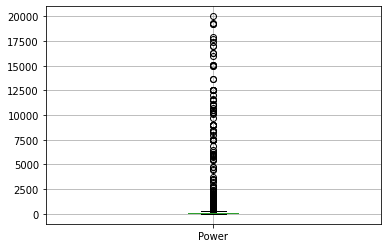

In [28]:
plt.figure()
df.boxplot(['Power'])

In [29]:
df['Power'].quantile(0.99)

299.0

In [30]:
df = df.drop(df[df.Power > 2000].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334498 entries, 0 to 354368
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Price             334498 non-null  int64
 1   RegistrationYear  334498 non-null  int64
 2   Power             334498 non-null  int64
 3   Model             334498 non-null  int64
 4   Mileage           334498 non-null  int64
 5   Brand             334498 non-null  int64
 6   DateCreated       334498 non-null  int16
 7   LastSeen          334498 non-null  int16
 8   VT_convertible    334498 non-null  uint8
 9   VT_coupe          334498 non-null  uint8
 10  VT_other          334498 non-null  uint8
 11  VT_sedan          334498 non-null  uint8
 12  VT_small          334498 non-null  uint8
 13  VT_suv            334498 non-null  uint8
 14  VT_wagon          334498 non-null  uint8
 15  GB_manual         334498 non-null  uint8
 16  FT_electric       334498 non-null  uint8
 17  FT_gasolin

In [31]:
df['Price'].quantile(0.99)

18800.0

## Model training

In [42]:
def eval_regressor(y_true, y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #sqrt(mean_squared_error(y_actual, y_predicted))
    #print(f'RMSE: {rmse:.2f}')
    return rmse

In [33]:
X = df.drop('Price', axis=1)
y = df['Price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,random_state=12345)

In [35]:
ss = StandardScaler()
ss.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(ss.transform(X_train), columns = columns)
X_test = pd.DataFrame(ss.transform(X_test), columns = columns)

In [43]:
reg = LinearRegression().fit(X_train, y_train)
pred_lr = reg.predict(X_test)
accuracy_lr = eval_regressor(y_test, pred_lr)
accuracy_lr

3054.475170145372

In [44]:
model_dt = DecisionTreeRegressor(random_state=12345)
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
accuracy_dt = eval_regressor(y_test, predictions_dt)
accuracy_dt

2277.224025759368

In [45]:
rmse = make_scorer(eval_regressor, greater_is_better=False)

In [46]:
def train_fit_score(model, params, name):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=rmse, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [47]:
%%time
#Create Linear Regressor
LinearRegressor = train_fit_score(LinearRegression(), {}, 'Linear Regressor')

CPU times: user 1.96 s, sys: 1.24 s, total: 3.2 s
Wall time: 3.2 s


In [48]:
LinearRegressor

,Estimator,Best Score,Best Params
0,Linear Regressor,3056.53704,{}


In [49]:
%%time
DecisionTree =train_fit_score(DecisionTreeRegressor(random_state=12345),
                              {"max_depth" : [1,5,12],
                               "min_samples_leaf":[1,5,10],
                               "max_leaf_nodes":[None,10,50,90] }, 'Decision Tree')

CPU times: user 1min 7s, sys: 2.02 s, total: 1min 9s
Wall time: 1min 10s


In [50]:
DecisionTree

,Estimator,Best Score,Best Params
0,Decision Tree,1955.025832,"{'max_depth': 12, 'max_leaf_nodes': None, 'min..."


In [51]:
%%time
RandomForest = train_fit_score(RandomForestRegressor(random_state=12345), 
                       {'n_estimators' : range(10, 85, 25),
                        'max_depth' : range(5, 45, 10),
                        'min_impurity_decrease' : np.arange(.05, .25, .1)}, 'Random Forest')

CPU times: user 56min 46s, sys: 20.8 s, total: 57min 7s
Wall time: 57min 8s


In [52]:
scores = pd.concat([LinearRegressor,DecisionTree, RandomForest]).set_index('Estimator')
scores['Best Score'] = scores['Best Score'].round(2)
display(scores.drop('Best Params', axis=1))

,Best Score
Estimator,
Linear Regressor,3056.54
Decision Tree,1955.03
Random Forest,1704.34


**Gradient boosting**

In [53]:
%%time
lgbm = ltb.LGBMRegressor(random_state=12345)
lgbm.fit(X_train, y_train)
print(); print(lgbm)

expected_y  = y_test
predicted_y = lgbm.predict(X_test)

print(eval_regressor(expected_y, predicted_y))


 


LGBMRegressor(random_state=12345)
1765.8012201531699
CPU times: user 2min 58s, sys: 1.12 s, total: 2min 59s
Wall time: 3min 1s


In [54]:
%%time
lgbm = train_fit_score(ltb.LGBMRegressor(random_state=12345), 
                       {'num_leaves' : range(10, 85, 25),
                        'max_depth' : range(5, 45, 10),
                        'min_data_in_leaf' : range(20, 420, 200)}, 'LightGBM')


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

In [55]:
lgbm

,Estimator,Best Score,Best Params
0,LightGBM,1725.270922,"{'max_depth': 25, 'min_data_in_leaf': 20, 'num..."


In [56]:
%%time
xgbr = train_fit_score(xgb.XGBRegressor(random_state=12345), 
                       {'max_depth': [6,10],
                        'n_estimators': range(100, 300,100)},'XGBoost')

CPU times: user 1h 5min 26s, sys: 16.5 s, total: 1h 5min 43s
Wall time: 1h 6min 10s


In [57]:
xgbr

,Estimator,Best Score,Best Params
0,XGBoost,1666.10061,"{'max_depth': 10, 'n_estimators': 100}"


In [58]:
scores_gb = pd.concat([lgbm, xgbr]).set_index('Estimator')
scores_gb['Best Score'] = scores_gb['Best Score'].round(2)
display(scores_gb.drop('Best Params', axis=1))

,Best Score
Estimator,
LightGBM,1725.27
XGBoost,1666.10


## Model analysis

In [59]:
%%time
accuracy_lr= round(accuracy_lr, 2)
print(f'RMSE for Linear Regression model on test datasets: {accuracy_lr}')

RMSE for Linear Regression model on test datasets: 3054.48
CPU times: user 203 µs, sys: 1e+03 ns, total: 204 µs
Wall time: 150 µs


In [73]:
%time rfr = RandomForestRegressor(**scores['Best Params'][2]).fit(X_train, y_train)

%time RandomForest_rmse = round(eval_regressor(y_test, rfr.predict(X_test)), 2)

#Print the result.
print(f'RMSE for best Random Forest model on test datasets: {RandomForest_rmse}')

CPU times: user 1min 23s, sys: 122 ms, total: 1min 23s
Wall time: 1min 23s
CPU times: user 1.81 s, sys: 4.34 ms, total: 1.82 s
Wall time: 1.82 s
RMSE for best Random Forest model on test datasets: 1690.39


In [72]:
%time lgbm_model = ltb.LGBMRegressor(**scores_gb['Best Params'][0]).fit(X_train, y_train)

%time lgbm_rmse = round(eval_regressor(y_test, lgbm_model.predict(X_test)), 2)

#Print the result.
print(f'RMSE for best LightGBM model on test datasets: {lgbm_rmse}')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
CPU times: user 9.55 s, sys: 55.5 ms, total: 9.61 s
Wall time: 9.66 s
CPU times: user 666 ms, sys: 0 ns, total: 666 ms
Wall time: 700 ms
RMSE for best LightGBM model on test datasets: 1715.81


In [74]:
%time xgbr_model = xgb.XGBRegressor(**scores_gb['Best Params'][1]).fit(X_train, y_train)


%time xgbr_rmse = round(eval_regressor(y_test, xgbr_model.predict(X_test)), 2)

#Print the result.
print(f'RMSE for best XGBoost model on test datasets: {xgbr_rmse}')

CPU times: user 2min 26s, sys: 280 ms, total: 2min 26s
Wall time: 2min 27s
CPU times: user 514 ms, sys: 0 ns, total: 514 ms
Wall time: 513 ms
RMSE for best XGBoost model on test datasets: 1651.3


## Conclusions

1. Linear Regression model is used as sanity check model. It has the shortest time of training and prediction and the lowest accurasy.

2. Random Forest model gave us more accurate results than LightGBM model but LightGBM was faster.

3. XGBoost model gave us the most accurate results but required the most time out of all other models for training. 
    But it was the fastest model to predict the result.